<a href="https://colab.research.google.com/github/reginaramirezo/AnalysisOfBigData/blob/main/Regina_ML_cifar_CNN_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


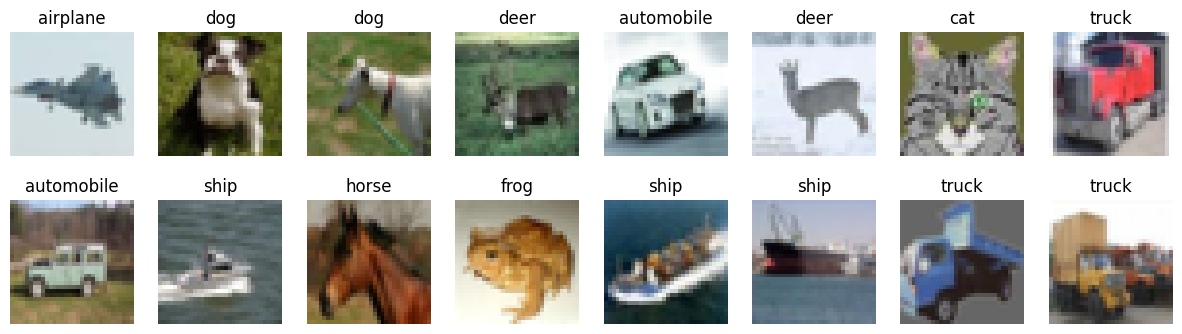

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import LeakyReLU

In [1]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_custom_cnn(input_shape, num_classes):
    model = Sequential()

    #In here I am doing the initial feature extraction layer
    model.add(Conv2D(64, (5,5), activation='relu', padding='valid', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3,3)))

    #With this function I am adding a deper feature extraction
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # I am adding depth with one more convolutional layer
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Finally this is a flattening step before dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model
    ### END STUDENT CODE ###


This CNN processes the images by passing them through many layers to identify and extract key features and classify them into categories. The model starts with convolutional layers which apply filters to detect any patterns like edges and textures in the images which will be the key to classify them succesfulyy in the end. These feature maps are then normalized using BatchNormalization to stabilize learning. We then have pooling layers which are inculded because tehy reduce the spatial dimensions of the feature maps, making the code more efficient. I added dropout layers to not overfit the model. They randomly deactivate some neurons during training.
The extracted features are then flattened and passed through fully connected layers, which are the ones that learn complex patterns and relationships between the features. Finally, the last dense layer with a softmax activation function gives a probability distribution over the possible classes, which is the thing that allows the model to make accurate predictions.

In [10]:
### STUDENT CODE HERE ###

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_val, y_val) = cifar10.load_data()

#Here I will normalize pixel values (between 0 and 1)
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0

# I am converting the labels to categorical
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)


# This are the training parameters
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 15

# In here I clear previous models from memory to have a better performance
tf.keras.backend.clear_session()

# This is the actual creation and compilation of the model
input_shape = (32, 32, 3)
NUM_CLASSES = 10
cnn_model = create_custom_cnn(input_shape, NUM_CLASSES)
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

def lr_schedule(epoch):
    return max(LEARNING_RATE * (0.5 ** (epoch // 5)), 1e-6)  # Reduce LR every 5 epochs

lr_scheduler = LearningRateScheduler(lr_schedule)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# I am training the model here
training_history = cnn_model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks=[lr_scheduler, model_checkpoint]  # Dynamic LR and model saving
)

# This is to save model weights
cnn_model.save_weights("trained_weights.weights.h5")

#In here you can find the model summary
cnn_model.summary()

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2596 - loss: 2.0448

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2596 - loss: 2.0447 - val_accuracy: 0.3373 - val_loss: 1.9090 - learning_rate: 0.0010
Epoch 2/15
1554/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4797 - loss: 1.4610

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4798 - loss: 1.4607 - val_accuracy: 0.3957 - val_loss: 1.7904 - learning_rate: 0.0010
Epoch 3/15
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5582 - loss: 1.2796

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5582 - loss: 1.2795 - val_accuracy: 0.5537 - val_loss: 1.4266 - learning_rate: 0.0010
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6092 - loss: 1.1450 - val_accuracy: 0.5035 - val_loss: 1.6053 - learning_rate: 0.0010
Epoch 5/15
1554/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6431 - loss: 1.0508

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6431 - loss: 1.0507 - val_accuracy: 0.6560 - val_loss: 1.1070 - learning_rate: 0.0010
Epoch 6/15
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6988 - loss: 0.8909

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6988 - loss: 0.8908 - val_accuracy: 0.6983 - val_loss: 0.9370 - learning_rate: 5.0000e-04
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7159 - loss: 0.8371 - val_accuracy: 0.6636 - val_loss: 1.1129 - learning_rate: 5.0000e-04
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7340 - loss: 0.7954 - val_accuracy: 0.6694 - val_loss: 1.0065 - learning_rate: 5.0000e-04
Epoch 9/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7463 - loss: 0.7505 - val_accuracy: 0.6877 - val_loss: 0.9825 - learning_rate: 5.0000e-04
Epoch 10/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7553 - loss: 0.7296 - val_accuracy: 0.7179 - val_loss: 1.1778 - learning_rate: 5.0000e-04
Epoch 11/15
1558/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7842 - loss: 0.6412

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7842 - loss: 0.6412 - val_accuracy: 0.7579 - val_loss: 0.7872 - learning_rate: 2.5000e-04
Epoch 12/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7933 - loss: 0.6146 - val_accuracy: 0.7437 - val_loss: 0.9264 - learning_rate: 2.5000e-04
Epoch 13/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8014 - loss: 0.5875 - val_accuracy: 0.7653 - val_loss: 0.8416 - learning_rate: 2.5000e-04
Epoch 14/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8073 - loss: 0.5703 - val_accuracy: 0.7741 - val_loss: 0.7876 - learning_rate: 2.5000e-04
Epoch 15/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8127 - loss: 0.5546 - val_accuracy: 0.7753 - val_loss: 0.8492 - learning_rate: 2.5000e-04


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 9, 9, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,111,894 (8.06 MB)

 Trainable params: 1,055,562 (4.03 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 1,055,564 (4.03 MB)

In [15]:
cnn_model.load_weights("trained_weights.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


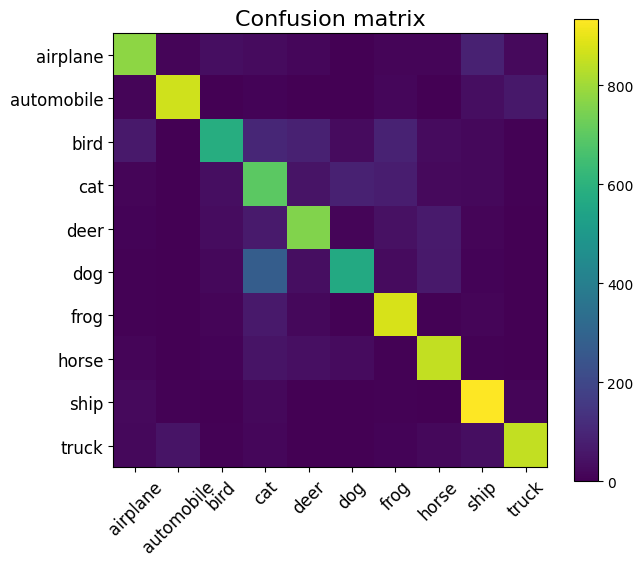

Test accuracy: 0.7753


In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

#In here I am defining the cifar10_classes function
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Load dataset
(_, _), (x_test, y_test) = cifar10.load_data()

#Here we are again normalizing the pixel values (scale between 0 and 1)
x_test = x_test.astype("float32") / 255.0

# Again we are converting to categorical
y_test = to_categorical(y_test, 10)

# This is to recreate the model using the same function
cnn_model = create_custom_cnn(input_shape, NUM_CLASSES)

# Here we lead the previously saved weights
cnn_model.load_weights("trained_weights.weights.h5")

# This is to make new predictions
y_pred_test = cnn_model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# In the following you can find the confussion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

The diagonal elements, which represent correctly classified samples, are significantly bright, indicating strong classification performance for most classes. It is important for me to mention, some off-diagonal elements exhibit noticeable intensity, particularly in classes like "dog" and "cat," suggesting that the model often confuses these categories. The missclassification that is happening in this areas suggetsts that the model struggles with fine-grained distinctions between visually similar classes, such as distinguishing between birds and airplanes or between automobiles and trucks.
The model achieves an overall accuracy of 77.53%, which is a solid performance but leaves room for improvement.
Some possible enhancements can be: data augmentation, hyperparameter tuning, or increasing model depth to better capture complex features.
In conclusion, while the CNN performs well on CIFAR-10, refining certain aspects could further reduce misclassification rates and boost accuracy.

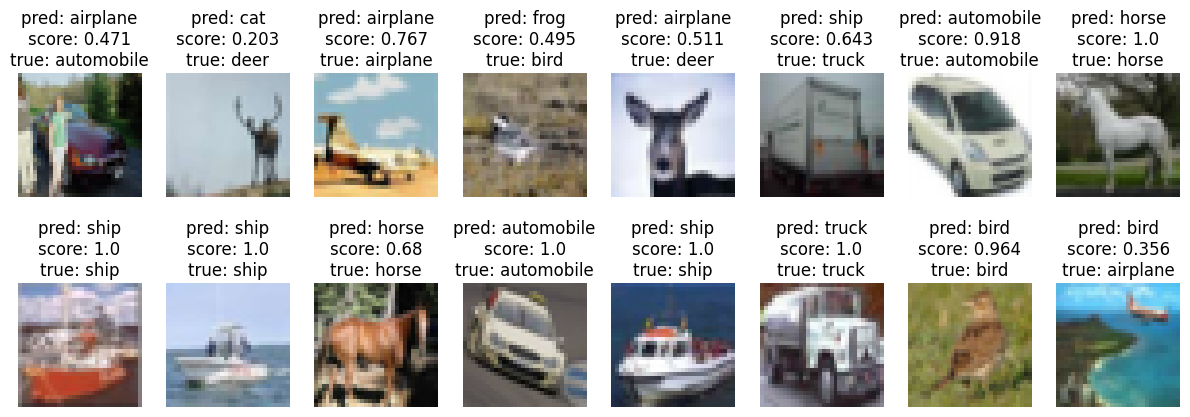

In [24]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


